In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models
import corner
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [2]:
def masking(rs_mass,mask,min_mass):
    x_masked=rs_mass.copy()
    x_masked=x_masked[mask]
    x_masked=x_masked[x_masked[:,1]>min_mass]
    return x_masked

def kde_sklearn(data,min_mass, bandwidth = 1.0):
    xgrid = np.linspace(min_mass,11.5,1000)
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

def KDE_binning(x,min_mass):
    bwrange = np.linspace(0.01,1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
    K = 5 # Do 5-fold cross validation
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
    grid.fit(x[:,None]) #Fit the histogram data that we started the lecture with.
    h_opt = grid.best_params_['bandwidth']
    pdf=kde_sklearn(x,min_mass,h_opt)
    return pdf
    

In [4]:
#import data
data_= fits.open('catalogs/3dhst_catalogue.fits');
rs = data_[1].data['Redshift']
mass = data_[1].data['Log_stellar_mass_Msun']
rs_mass = np.column_stack((rs,mass))

In [5]:
#masks definition
mask1=(rs_mass[:,0]>2)
mask2=((rs_mass[:,0]>1.5) & (rs_mass[:,0]<2))
mask3=((rs_mass[:,0]>1) & (rs_mass[:,0]<1.5))
mask4=((rs_mass[:,0]>0.5) & (rs_mass[:,0]<1))
masks=[mask1,mask2,mask3,mask4]

In [6]:
#finding the minimum mass
min_mass=np.min(rs_mass[mask1][:,1])

In [7]:
#masking data
rs_mass_masked=masking(rs_mass,mask1,min_mass)

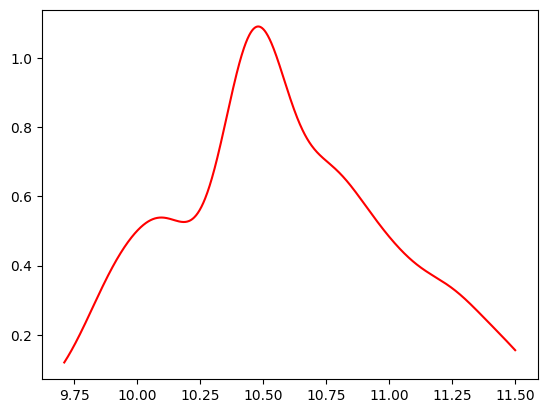

In [8]:
#producing pdf by kernel density estimation
pdf=KDE_binning(rs_mass_masked[:,1],min_mass)
xgrid=np.linspace(min_mass,11.5,1000)
plt.plot(xgrid,pdf,c='red')

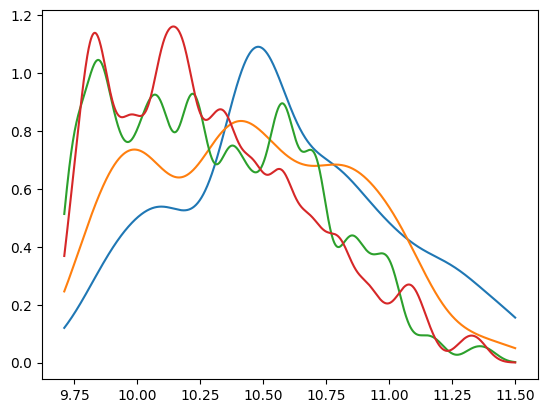

In [9]:
pdfs=[]
indeces=[1,2,3,4]
xgrid=np.linspace(min_mass,11.5,1000)
for mask in masks:
    x=masking(rs_mass,mask,min_mass)
    pdfs.append(KDE_binning(x[:,1],min_mass))
for pdf,i in zip(pdfs,indeces):
    plt.plot(xgrid,pdf,label='mask'+str(i))
plt.show()